<a href="https://colab.research.google.com/github/Gnemasime/Time-Series-Forecasting-with-LSTMs/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up the environment and install required packages

In [ ]:
!pip install yfinance pandas numpy matplotlib scikit-learn statsmodels tensorflow


Import necessary libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


Download and preprocess the data

[*********************100%%**********************]  1 of 1 completed


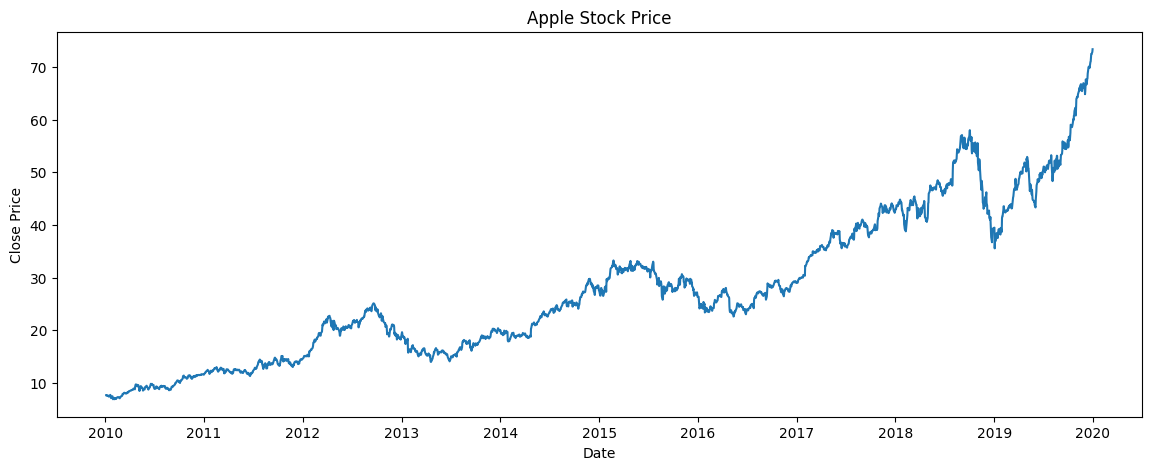

In [ ]:
# Download stock price data (e.g., Apple stock prices)
df = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
df = df['Close']

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(df)
plt.title('Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Preprocess the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Create a dataset with look-back
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, Y = create_dataset(df_scaled, look_back)

# Split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))


Build and train the LSTM model

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1964/1964 ━━━━━━━━━━━━━━━━━━━━ 60s 29ms/step - loss: 0.0020
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Plot the results

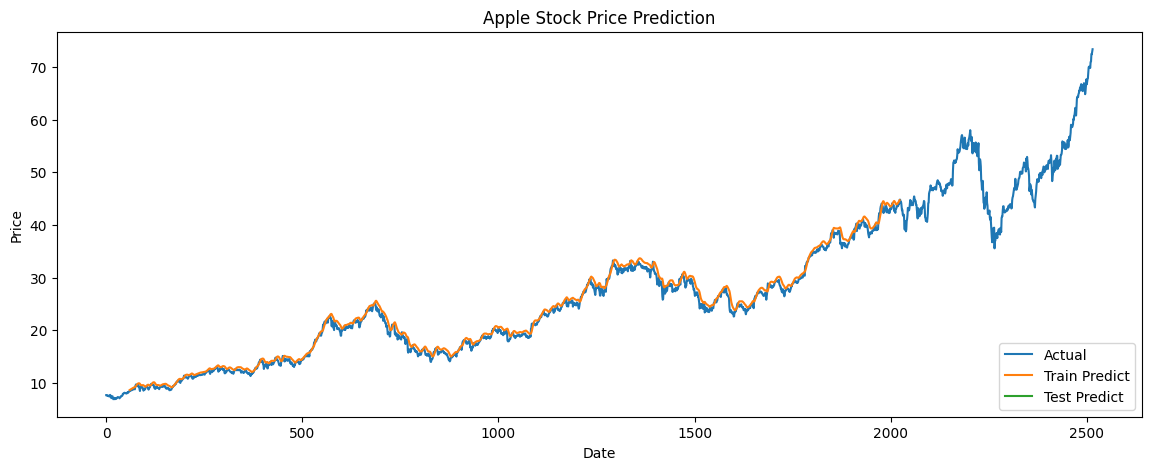

In [ ]:
# Create empty arrays to store the predictions
train_plot = np.empty_like(df_scaled)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_plot = np.empty_like(df_scaled)
test_plot[:, :] = np.nan
#test_plot[len(train_predict) + (look_back * 2):len(df_scaled), :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(df_scaled), label='Actual Price')
plt.plot(train_plot, label='Train Predict')
plt.plot(test_plot, label='Test Predict')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Actual', 'Train Predict', 'Test Predict'], loc='lower right')
plt.show()


Build and evaluate an ARIMA model

In [ ]:
# Fit ARIMA model
arima_order = (5, 1, 0)
train_arima = df[:train_size]
test_arima = df[train_size:]

model_arima = ARIMA(train_arima, order=arima_order)
model_arima_fit = model_arima.fit()

# Forecast
forecast_arima = model_arima_fit.forecast(steps=len(test_arima)) # Remove the [0] indexing here

# Calculate RMSE for LSTM and ARIMA
rmse_lstm = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
# Access the values of the forecast_arima Series using .values
rmse_arima = np.sqrt(mean_squared_error(test_arima.values, forecast_arima.values))

print(f'LSTM RMSE: {rmse_lstm}')
print(f'ARIMA RMSE: {rmse_arima}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LSTM RMSE: 1.5636021740438601
ARIMA RMSE: 12.469529234584854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


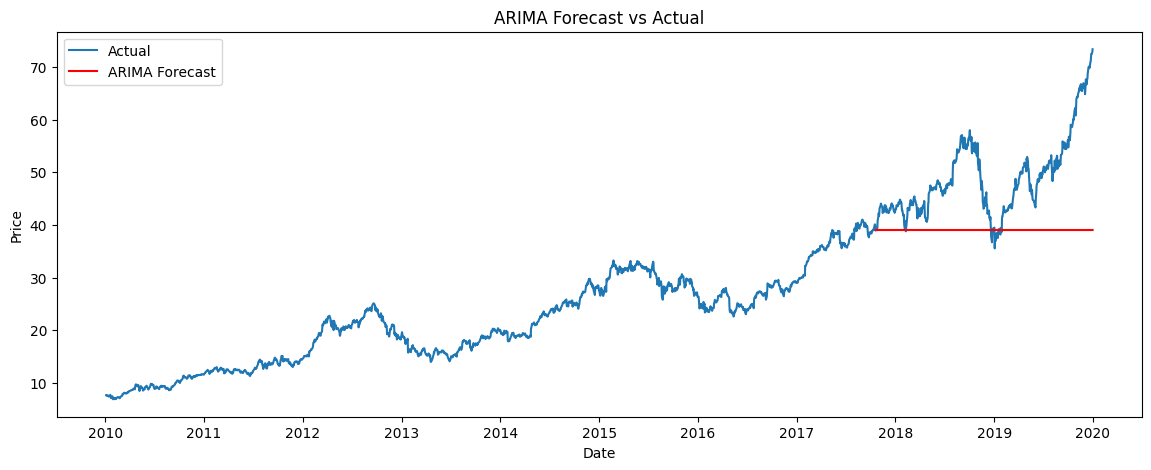

In [ ]:
# Plot ARIMA forecast
plt.figure(figsize=(14, 5))
plt.plot(df.index, df, label='Actual')
plt.plot(test_arima.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
